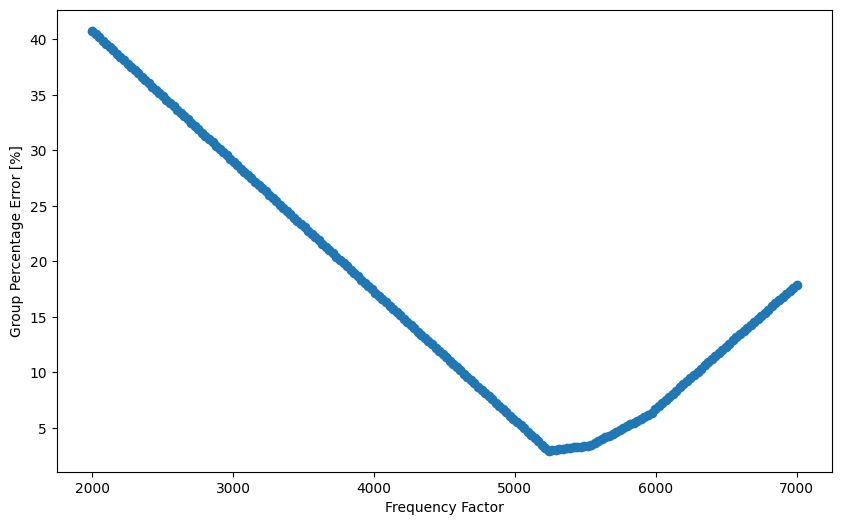

Lowest group percentage error: 2.93% at index 129
Best k value: 5241.206030150754
Mass fractions for the best k:
Urea: 0.00128175723
Carbamate: 0.525181797
CO2: 0.117984941
NH3: 0.273818233
H2O: 0.0706264274


In [19]:
# Import necessary libraries
import os
import win32com.client as win32  # For COM connection with Aspen Plus
import numpy as np  # For numerical calculations
import time  # To pause code execution for Aspen run completion
import pandas as pd  # To create and manipulate dataframes
import matplotlib.pyplot as plt  # For creating plots

# Define the Aspen Plus simulation file path
Aspenfilepath = r'Template_carb\Urea_reactor_biuret.bkp'

# Create a COM connection with Aspen Plus
Aspen = win32.Dispatch('Apwn.document')
Aspen.InitFromArchive2(os.path.abspath(Aspenfilepath))  # Initialize simulation from the file
Aspen.Engine.Run2()  # Run the simulation
Aspen.Visible = True  # Optional: Make the Aspen window visible
Aspen.SuppressDialogs = 1  # Suppress dialogs to avoid interruptions

# Define the Aspen data nodes for different mass fractions and reaction parameters
K_node = r'\Data\Reactions\Reactions\R2\Input\PRE_EXP\1'
Urea_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\UREA'
Carb_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\CARB'
CO2_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\CO2'
NH3_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\NH3'
H2O_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\H2O'
Biuret_mass_fraction_node = r'\Data\Streams\CARBPROD\Output\MASSFRAC\MIXED\BIURETU'

# Define the range of K (frequency factor) to test
K_array = np.linspace(2000, 7000, 200)

# Initialize lists to store the mass fractions at each K value
Urea, Carb, CO2, NH3, H2O, Biuret = [], [], [], [], [], []

# Loop through each K value, update the Aspen model, and retrieve mass fractions
for k in K_array:
    #print(k)
    Aspen.Tree.FindNode(K_node).Value = float(k)  # Set the frequency factor
    Aspen.Reinit()
    Aspen.Engine.Run2()  # Run the Aspen simulation

    # Wait until the simulation is finished
    while Aspen.Engine.IsRunning:
        time.sleep(0.5)

    # Retrieve the mass fractions for each component
    Urea.append(Aspen.Tree.FindNode(Urea_mass_fraction_node).Value)
    Carb.append(Aspen.Tree.FindNode(Carb_mass_fraction_node).Value)
    CO2.append(Aspen.Tree.FindNode(CO2_mass_fraction_node).Value)
    NH3.append(Aspen.Tree.FindNode(NH3_mass_fraction_node).Value)
    H2O.append(Aspen.Tree.FindNode(H2O_mass_fraction_node).Value)
    Biuret.append(Aspen.Tree.FindNode(Biuret_mass_fraction_node).Value)

# Close the Aspen Plus connection
Aspen.Close()

# Function to calculate percentage error between measured and reference values
def Calculate_percentage_error(measured, reference):
    return np.abs((measured - reference) / reference) * 100

# Define reference mass fractions for comparison (urea, carb, CO2, NH3, H2O, biuret)
Reference_mass_frac = np.array([0.00126236828037646, 0.545746242227888, 0.11804232374056, 0.252436689248328, 0.0712285977656909, 0])

# Calculate percentage errors for each component
Error_urea = Calculate_percentage_error(Urea, Reference_mass_frac[0])
Error_carb = Calculate_percentage_error(Carb, Reference_mass_frac[1])
Error_co2 = Calculate_percentage_error(CO2, Reference_mass_frac[2])
Error_nh3 = Calculate_percentage_error(NH3, Reference_mass_frac[3])
Error_h2o = Calculate_percentage_error(H2O, Reference_mass_frac[4])
#Error_biuret = np.ones(100) * 100  # Assume 100% error for biuret as reference is zero

# Function to compute the group percentage error for each frequency factor
def compute_group_percentage_error(Urea, Carb, CO2, NH3, H2O, Reference_mass_frac):
    # Initialize a list to store the group percentage error for each frequency factor
    group_errors = []

    # Loop through each frequency factor (row in Urea, Carb, etc.)
    for i in range(len(Urea)):
        # Calculate percentage errors for all species
        error_urea = Calculate_percentage_error(Urea[i], Reference_mass_frac[0])
        error_carb = Calculate_percentage_error(Carb[i], Reference_mass_frac[1])
        error_co2 = Calculate_percentage_error(CO2[i], Reference_mass_frac[2])
        error_nh3 = Calculate_percentage_error(NH3[i], Reference_mass_frac[3])
        error_h2o = Calculate_percentage_error(H2O[i], Reference_mass_frac[4])
        
        # Combine the errors into a single metric (e.g., mean of all species' errors)
        mean_error = np.mean([error_urea, error_carb, error_co2, error_nh3, error_h2o])
        
        # Append the group error for this frequency factor
        group_errors.append(mean_error)
    
    return np.array(group_errors)

# Calculate the group percentage error for each frequency factor
group_percentage_errors = compute_group_percentage_error(Urea, Carb, CO2, NH3, H2O, Reference_mass_frac)

# Print the error for each frequency factor
#for i, error in enumerate(group_percentage_errors):
    #print(f"Frequency Factor {i+1}: Group Percentage Error = {error:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(K_array, group_percentage_errors, marker='o')
plt.xlabel('Frequency Factor')
plt.ylabel('Group Percentage Error [%]')
#plt.title('Frequency Factor vs Group Percentage Error')
#plt.grid(True)
plt.show()

# Find the index of the minimum error
min_error_index = np.argmin(group_percentage_errors)
min_error = group_percentage_errors[min_error_index]

# Get the mass fractions for the test with the lowest error
best_urea = Urea[min_error_index]
best_carb = Carb[min_error_index]
best_co2 = CO2[min_error_index]
best_nh3 = NH3[min_error_index]
best_h2o = H2O[min_error_index]

# Get the corresponding k value
best_k = K_array[min_error_index]

# Print the results
print(f"Lowest group percentage error: {min_error:.2f}% at index {min_error_index}")
print(f"Best k value: {best_k}")
print("Mass fractions for the best k:")
print(f"Urea: {best_urea}")
print(f"Carbamate: {best_carb}")
print(f"CO2: {best_co2}")
print(f"NH3: {best_nh3}")
print(f"H2O: {best_h2o}")

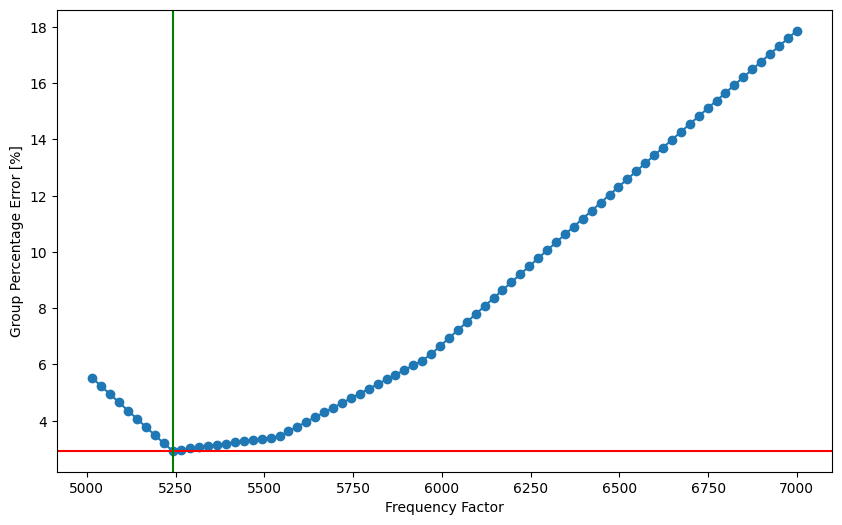

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(K_array[120:], group_percentage_errors[120:], marker='o')
plt.axhline(2.93, color='red')
plt.axvline(5241.20, color='green')
plt.xlabel('Frequency Factor')
plt.ylabel('Group Percentage Error [%]')
#plt.title('Frequency Factor vs Group Percentage Error')
#plt.grid(True)
plt.show()